In [70]:
import numpy as np
import pandas as pd
import seaborn as sns
from hmmlearn.hmm import GMMHMM
from matplotlib import pyplot as plt

In [77]:
file = "../3自定义轴/bar_label"  #################  轴文件

L = 5  ### 1阶与X阶
diff = 1  ### 1是有HLdiff，0是没有HLdiff
mix = 3  ### GMM mix参数

####################################################################################


file_name = file + ".csv"
df = pd.read_csv(file_name)

close = df["close"]
high = df["high"][L:]
low = df["low"][L:]
eob = df["eob"]
datelist = pd.to_datetime(eob[L:])


logreturn = (np.log(np.array(close[1:])) - np.log(np.array(close[:-1])))[(L - 1) :]
logreturnX = np.log(np.array(close[L:])) - np.log(np.array(close[:-L]))
HLdiff = np.log(np.array(high)) - np.log(np.array(low))


closeidx = close[L:]


if diff == 1:
    X = np.column_stack([HLdiff, logreturnX, logreturn])

else:
    X = np.column_stack([logreturnX, logreturn])


len(X)

5530

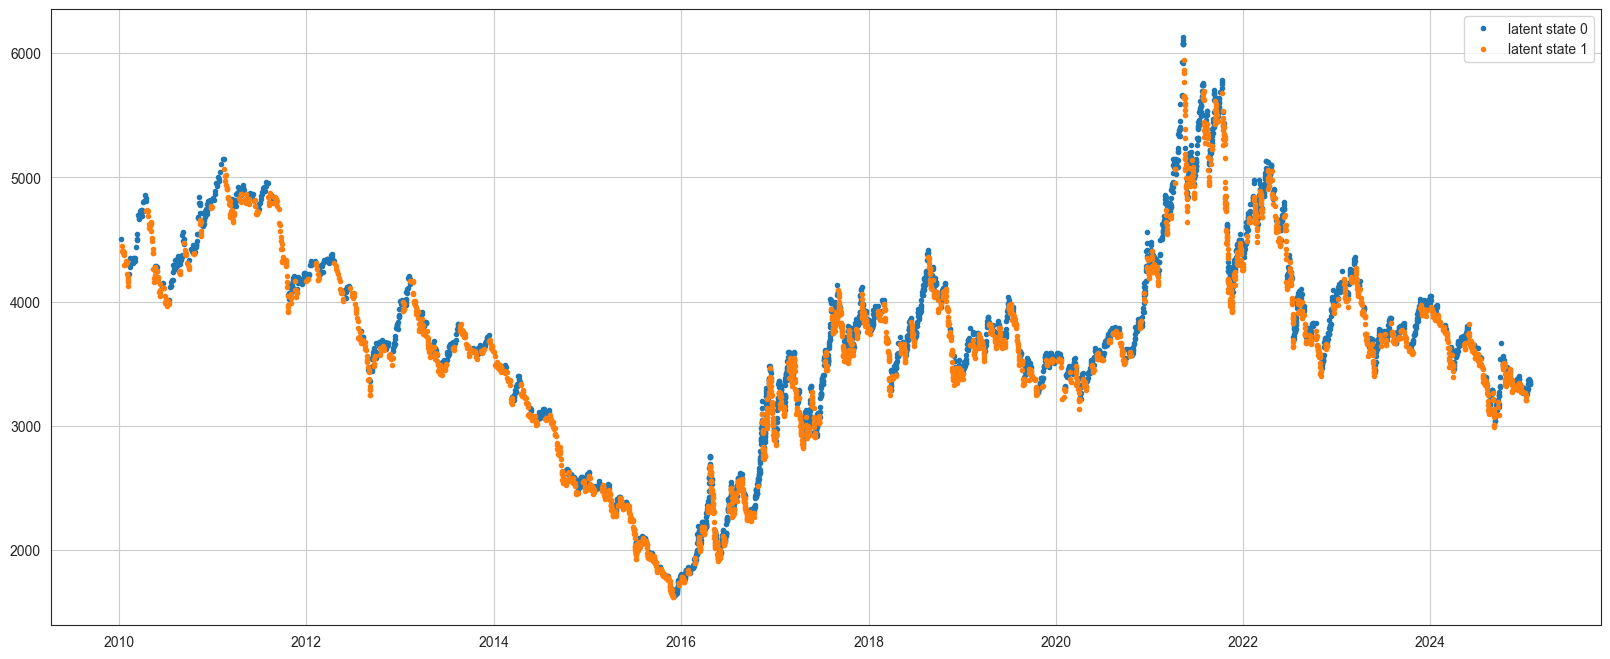

In [78]:
gmm = GMMHMM(
    n_components=2, n_mix=mix, covariance_type="diag", n_iter=369, random_state=42
).fit(X)

latent_states_sequence = gmm.predict(X)
len(latent_states_sequence)
sns.set_style("white")
plt.figure(figsize=(20, 8))
for i in range(gmm.n_components):
    state = latent_states_sequence == i
    plt.plot(datelist[state], closeidx[state], ".", label="latent state %d" % i, lw=1)
    plt.legend()
    plt.grid(1)


In [79]:
np.unique(latent_states_sequence, return_counts=True)

(array([0, 1]), array([2948, 2582]))

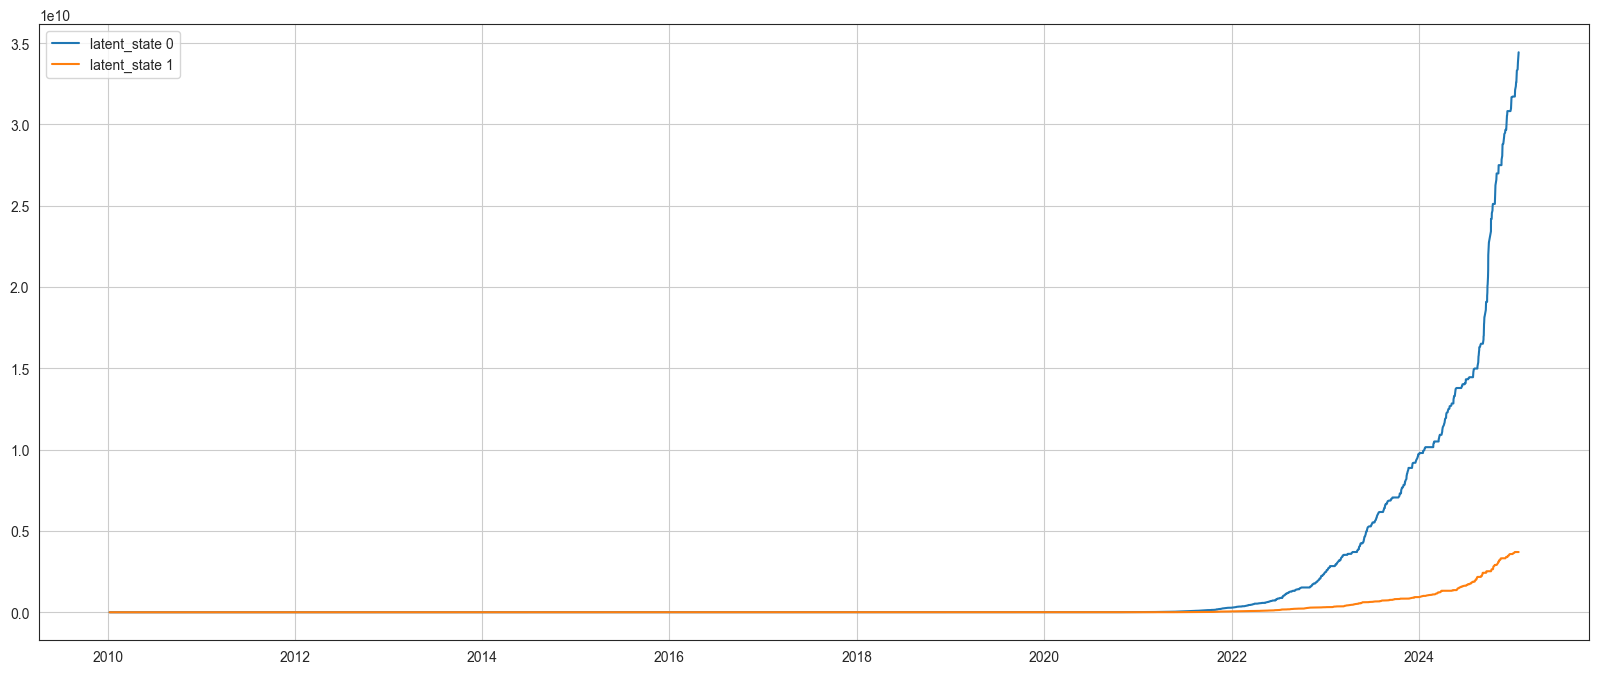

In [82]:
data = pd.DataFrame(
    {
        "datelist": datelist,
        "logreturn": np.abs(logreturn),
        "state": latent_states_sequence,
    }
).set_index("datelist")

plt.figure(figsize=(20, 8))
for i in range(gmm.n_components):
    state = latent_states_sequence == i
    idx = np.append(0, state[1:])
    data["state %d_return" % i] = data.logreturn.multiply(idx, axis=0)
    plt.plot(np.exp(data["state %d_return" % i].cumsum()), label="latent_state %d" % i)
    plt.legend(loc="upper left")
    plt.grid(1)

plt.savefig("Label_a.jpg")  ##############  保存图片    #####################


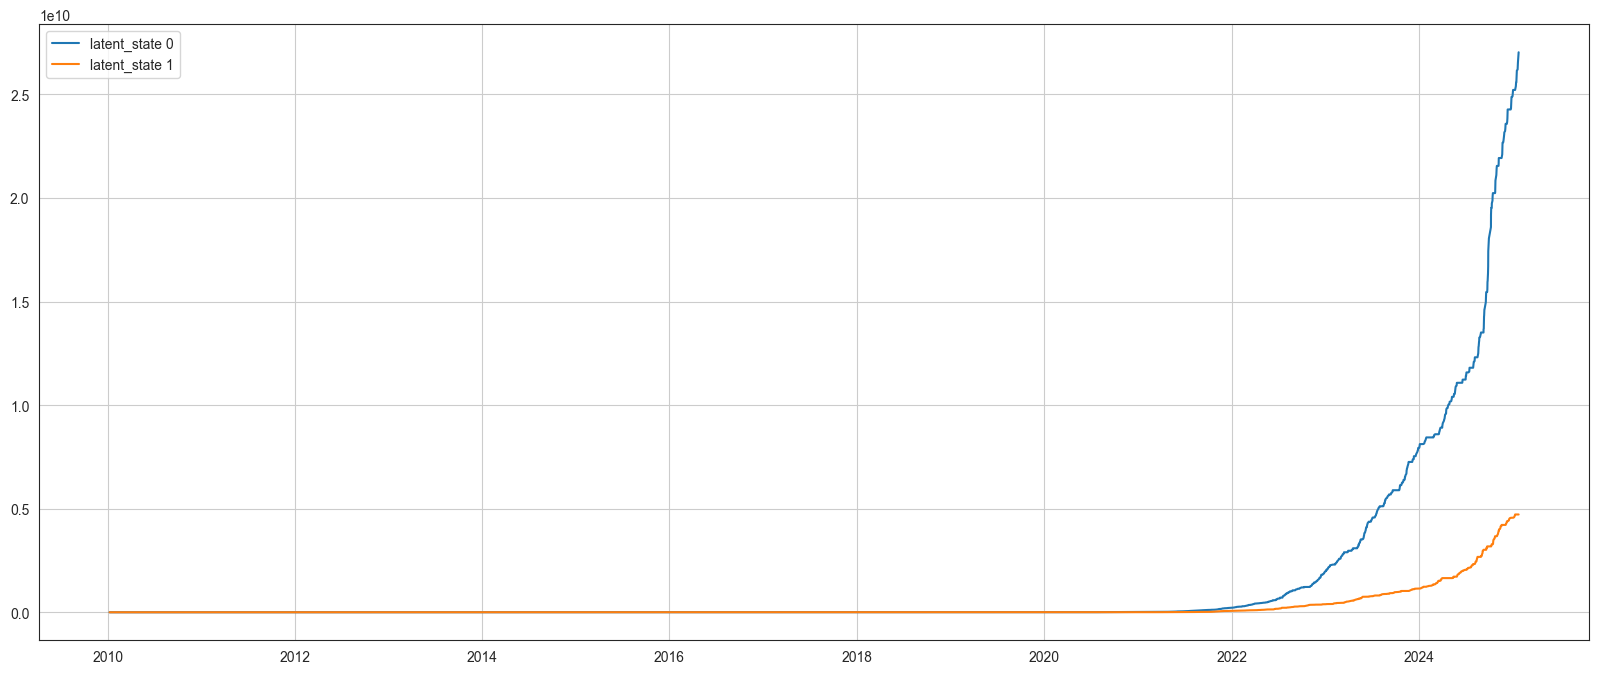

In [83]:
data = pd.DataFrame(
    {
        "datelist": datelist,
        "logreturn": np.abs(logreturn),
        "state": latent_states_sequence,
    }
).set_index("datelist")

plt.figure(figsize=(20, 8))
for i in range(gmm.n_components):
    state = latent_states_sequence == i
    idx = np.append(0, state[:-1])
    data["state %d_return" % i] = data.logreturn.multiply(idx, axis=0)
    plt.plot(np.exp(data["state %d_return" % i].cumsum()), label="latent_state %d" % i)
    plt.legend(loc="upper left")
    plt.grid(1)

plt.savefig("Label_b.jpg")  ##############  保存图片    #####################

In [32]:
# 自动判断，将标签的 1与0，变为buy为1，sell为0

if sum(data["state 0_return"]) > sum(data["state 1_return"]):
    data["state"] = abs(data["state"] - 1)


# 标签数据导出

data.to_csv("Label_" + str(L) + str(diff) + str(mix) + ".csv")